# **Using the Final Model**
Here we experiment with using the trained model to guide a flight purchase and explain how two different flights may differ

In [1]:
# Change CWD to repo base for imports
import os
from pathlib import Path
notebook_path = Path().resolve()
parent_directory = notebook_path.parent
if notebook_path.cwd().__str__().split("/")[-1] != "theory_of_ml_group4":
    os.chdir(parent_directory)

import matplotlib.pyplot as plt

# library imports
from etl import get_flight_data
from models import FlightPerformanceModel
import constants as c
# computation
import pandas as pd
import numpy as np
# model utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# models
from sklearn.linear_model import LogisticRegression, LinearRegression
from catboost import CatBoostClassifier, CatBoostRegressor

import logging
log = logging.getLogger("modeling")
log.setLevel(logging.INFO)

# use this for dev
# from importlib import reload
# import models
# reload(models)
# from models import FlightPerformanceModel

In [2]:
df = get_flight_data(sample_frac=0.50)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

reading data/202312_flights.csv
reading data/202307_flights.csv
reading data/202402_flights.csv
reading data/202209_flights.csv
reading data/202302_flights.csv
reading data/202210_flights.csv
reading data/202308_flights.csv
reading data/202404_flights.csv
reading data/202301_flights.csv
skipped data/state_region_map.csv
reading data/202401_flights.csv
skipped data/airport_id_map_old.csv
reading data/202304_flights.csv
reading data/202311_flights.csv
reading data/202406_flights.csv
reading data/202211_flights.csv
reading data/202303_flights.csv
reading data/202208_flights.csv
reading data/202403_flights.csv
reading data/202306_flights.csv
skipped data/airport_id_map.csv
reading data/202310_flights.csv
reading data/202305_flights.csv
reading data/202212_flights.csv
skipped data/airline_codes_map.csv
reading data/202405_flights.csv
reading data/202309_flights.csv
reading data/202207_flights.csv


## **Training the final model**

In [3]:

model = FlightPerformanceModel(
    targets={
        c.CANCELLED_COL: {
            "type": "classification",
            "estimator": CatBoostClassifier,
            "params": {"random_state": 42, "verbose": False}
        },
        c.DELAYED_COL: {
            "type": "classification",
            "estimator": CatBoostClassifier,
            "params": {"random_state": 42, "verbose": False}
        },
        c.DELAY_DURATION_COL: {
            "type": "regression",
            "estimator": CatBoostRegressor,
            "params": {"random_state": 42, "verbose": False}
        },
    },
)

model.fit(df_train.sample(frac=0.5, random_state=42))

Number of train rows with NaN: 0
22:55:23:Training model for target Cancelled
22:57:29:Model for target Cancelled trained.
22:57:29:Training model for target ArrDel15
22:59:34:Model for target ArrDel15 trained.
22:59:34:Training model for target ArrDelay
22:59:53:Model for target ArrDelay trained.


In [4]:
df_test = df_test.dropna(subset=model.feature_base_cols)

# Predict probabilities and calculate AUC for logistic regression model
for target_col in [c.CANCELLED_COL, c.DELAYED_COL]:
    y_pred_proba = model.predict_proba(df_test, target_col=target_col)
    logistic_auc = roc_auc_score(df_test[target_col].fillna(0), y_pred_proba)
    print(f"Logistic Regression AUC for {target_col}: {logistic_auc:.4f} vs. 0.50 baseline")

# Predict delay duration and calculate RMSE for linear regression model
y_true_delay_duration = df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL].fillna(0)
y_pred_delay_duration = model.predict(df_test.loc[(df_test[c.DELAYED_COL] == 1.0).values], target_col=c.DELAY_DURATION_COL)
linear_rmse = np.sqrt(np.mean((df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL] - y_pred_delay_duration)**2))
baseline_rmse = np.sqrt(np.mean(df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL]**2))
print(f"Linear Regression RMSE for {c.DELAY_DURATION_COL}: {linear_rmse:.4f} vs. {baseline_rmse:.4f} baseline")

Logistic Regression AUC for Cancelled: 0.7957 vs. 0.50 baseline
Logistic Regression AUC for ArrDel15: 0.6390 vs. 0.50 baseline
Linear Regression RMSE for ArrDelay: 97.6154 vs. 120.5082 baseline


## **Fitting SHAP and exploring feature importances**

  0%|          | 0/50 [00:00<?, ?it/s]

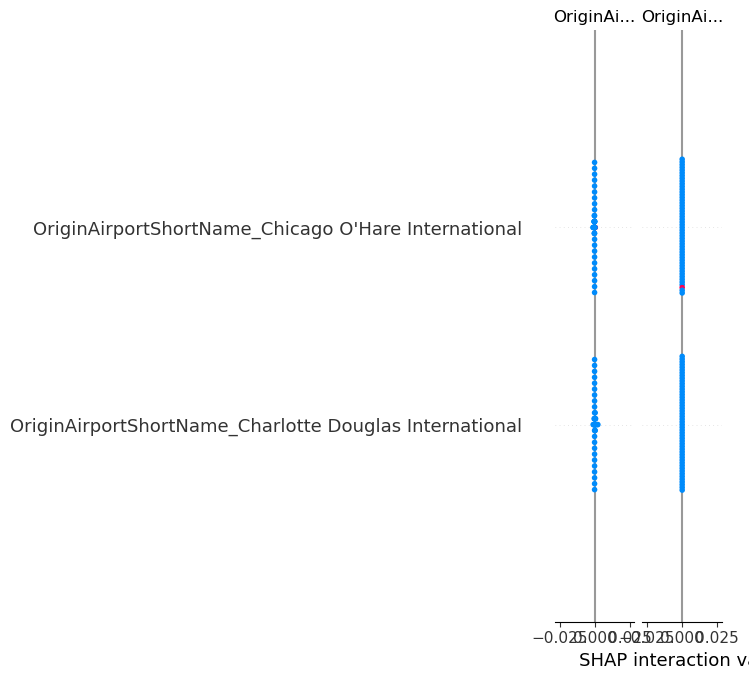

In [25]:
import shap

X_test = model._transform_to_df(df_test).sample(n=50)

# Create a SHAP explainer
explainer = shap.KernelExplainer(model.estimators[c.CANCELLED_COL].predict_proba, X_test)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
shap.summary_plot(shap_values, X_test)

In [6]:
# # Group SHAP values by original category
# grouped_shap_values = shap_values.values.copy()
# encoder = model.transformer.named_steps["preprocess"].transformers_[0][1]

# grouped_shaps = {}
# for i, category_name in enumerate(encoder.feature_names_in_.tolist()):
#     original_categories = encoder.categories_[i]
#     # Sum SHAP values for each category group
#     grouped_shap = pd.DataFrame(
#         grouped_shap_values[:, :len(original_categories)],
#         columns=original_categories
#     )
#     grouped_shap = grouped_shap.mean(axis=1)
#     grouped_shaps[category_name] = grouped_shap

# grouped_shaps = pd.DataFrame(grouped_shaps)
# grouped_shaps

## **Choosing between flights**

In [8]:
from datetime import date
DATA_PATH = Path() / "data"
AIRLINE_CODES_FILENAME = "airline_codes_map.csv"
AIRPORT_CODES_FILENAME = "airport_id_map.csv"

def preprocess_flight_metadata(df_prediction):
    airport_id_map = pd.read_csv(DATA_PATH / AIRPORT_CODES_FILENAME)
    df_prediction = pd.merge(df_prediction, airport_id_map.rename(columns={col:f"Origin{col.replace("_", "")}" for col in airport_id_map.columns}), left_on="OriginIATACode", right_on="OriginIATACode")
    df_prediction = pd.merge(df_prediction, airport_id_map.rename(columns={col:f"Dest{col.replace("_", "")}" for col in airport_id_map.columns}), left_on="DestIATACode", right_on="DestIATACode")
    return df_prediction

df_prediction = preprocess_flight_metadata(
    pd.DataFrame(
        {
            "OriginIATACode":["JFK", "JFK", "EWR", "EWR"],
            "DestIATACode":["LAX", "LAX", "LAX", "LAX"],
            "Airline_Name":["Delta Air Lines Inc.", "Delta Air Lines Inc.", "United Air Lines Inc.", "United Air Lines Inc."],
            "Distance":[2469.0]*4,
            "ScheduledDurationMinutes":[6*60+20] * 4,
            "FlightDate":[date(2024, 12, 10), date(2024, 12, 11), date(2024, 12, 10), date(2024, 12, 11)],
            "CRSDepTime":["17:30:00", "06:00:00", "17:30:00", "06:00:00"],
        }
    )
)

df_prediction

,OriginIATACode,DestIATACode,Airline_Name,Distance,ScheduledDurationMinutes,FlightDate,CRSDepTime,OriginCode,OriginAirportName,OriginAirportCity,...,OriginAirportShortName,OriginRegion,OriginDivision,DestCode,DestAirportName,DestAirportCity,DestAirportState,DestAirportShortName,DestRegion,DestDivision
0,JFK,LAX,Delta Air Lines Inc.,2469.0,380,2024-12-10,17:30:00,12478,"New York, NY: John F. Kennedy International",New York,...,John F. Kennedy International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
1,JFK,LAX,Delta Air Lines Inc.,2469.0,380,2024-12-11,06:00:00,12478,"New York, NY: John F. Kennedy International",New York,...,John F. Kennedy International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
2,EWR,LAX,United Air Lines Inc.,2469.0,380,2024-12-10,17:30:00,11618,"Newark, NJ: Newark Liberty International",Newark,...,Newark Liberty International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
3,EWR,LAX,United Air Lines Inc.,2469.0,380,2024-12-11,06:00:00,11618,"Newark, NJ: Newark Liberty International",Newark,...,Newark Liberty International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific


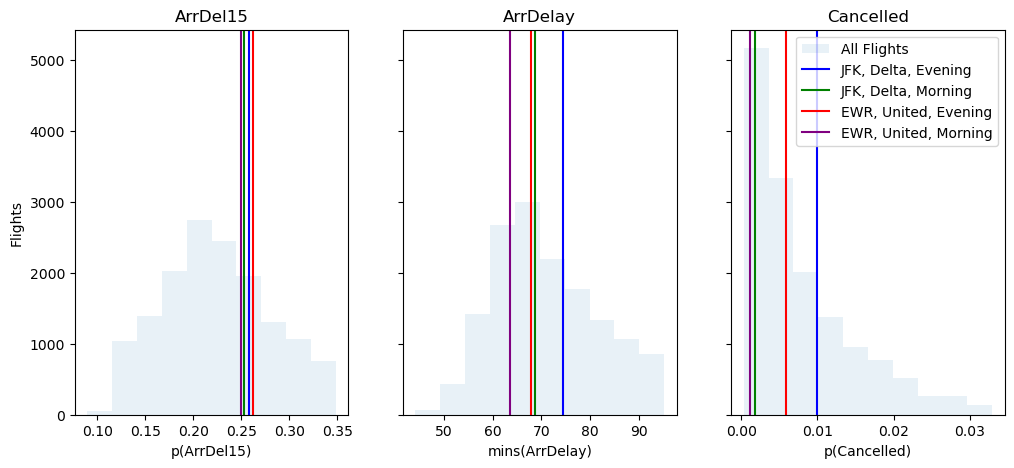

In [19]:
# Define the columns for subplots
columns = [c.DELAYED_COL, c.DELAY_DURATION_COL, c.CANCELLED_COL]

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Loop through the columns and create subplots
for n_col, (ax, col) in enumerate(zip(axes, columns)):
    mask = (df.Origin.isin(["EWR", "JFK"])) \
        & (df.Dest == "LAX")
    if col == c.DELAY_DURATION_COL:
        all_preds = model.predict(df.loc[mask], target_col=col,)
    else:
        all_preds = model.predict_proba(df.loc[mask], target_col=col,)
    all_preds = all_preds[all_preds < np.quantile(all_preds, 0.95)]
    
    ax.hist(
        all_preds,
        label="All Flights" if n_col == 2 else None,
        alpha=0.1,
    )

    preds = model.predict_on_time(df_prediction)
    flight_names = [
        "JFK, Delta, Evening",
        "JFK, Delta, Morning",
        "EWR, United, Evening",
        "EWR, United, Morning",
    ]
    for i, pred in preds.iterrows():
        ax.axvline(pred[col],
        label=flight_names[i] if n_col == 2 else None,
        color=["blue", "green", "red", "purple"][i])
    
    if n_col == 0:
        ax.set_ylabel("Flights")
    if n_col == 2:
        ax.legend()
    
    ax.set_title(col)
    ax.set_xlabel(f"{'p' if col != c.DELAY_DURATION_COL else "mins"}({col})")

In [32]:
# Calculate SHAP values for the prediction dataset
X_test = model._transform_to_df(df_prediction)
shap_values = explainer.shap_values(X_test)

# Create the force plot
# Ensure the correct SHAP values and expected value are used
base_value = explainer.expected_value  # Single output model
shap.plots.force(base_value, shap_values)

  0%|          | 0/4 [00:00<?, ?it/s]

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [ ]:
# comparison_df.sort_values(by="Difference")


,Feature,Instance 1 SHAP,Instance 2 SHAP,Difference,Instance 1 Value,Instance 2 Value
45,Airline_Name_Delta Air Lines Inc.,0.047911,-0.387645,0.435556,-0.405342,2.467054
6,OriginAirportShortName_LaGuardia,0.343703,-0.007014,0.350717,6.376150,-0.156834
75,day_of_week_2_Wednesday,-0.017107,0.068430,-0.085537,-0.404617,2.471475
8,OriginAirportShortName_Other,-0.032662,0.018372,-0.051034,-1.426064,0.701231
74,day_of_week_1_Tuesday,-0.026904,0.003669,-0.030573,2.492510,-0.401202
56,Airline_Name_Southwest Airlines Co.,-0.032530,-0.032530,0.000000,-0.510749,-0.510749
62,month_10,0.059038,0.059038,0.000000,-0.305482,-0.305482
61,month_1,-0.059944,-0.059944,0.000000,-0.293084,-0.293084
64,month_12,0.733099,0.733099,0.000000,3.342514,3.342514
63,month_11,0.086207,0.086207,0.000000,-0.296678,-0.296678
